## Setting up Neural Net

The code for the nueral network (called BinClassModel) was adapted from the neural network class from the machine learning course at CSU (CS 445), of which the instructor, Nikhil Krishnaswamy, gave me permission to use for this project. Because it's adapted from the assignment, out of an abundance of caution, I won't be able to share it here. I'm happy to share the code on request if desired.

The code is essentially a generalized version of a pytorch neural network that makes hyperparameter testing easier to perform. Pytorch makes creating a neural network incredibly easy, and therefore won't be hard to implement. See the paper for the general structure of the neural network properties.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


In [ ]:
# Function for finding profitability

def findPrecision(threshold, prob_col, win_col, verbose = False):
  pred_wins = np.where(prob_col > threshold, 1, 0)
  if (pred_wins.shape[0] == 0):
    return 0

  data = np.hstack((pred_wins,win_col))
  data = data[np.where(data[:,0] == 1)]
  if verbose:
    print(data.shape[0])
  precision = np.mean(data[:, 0] == data[:, 1])

  return f'{precision:.3f}'

# Profitability Plots

In [1]:
# Use with data
from google.colab import files
uploaded = files.upload()

In [ ]:
# Function for calculating max profits

def calculateProfitability(threshold, teamType, test_data, probabilities):
  
  moneylineHome = test_data['tb_money_line_Home'].tolist()
  moneylineAway = test_data['tb_money_line_Away'].tolist()
  
  if teamType == 'fav':
    actual_wins = test_data['fav_wins'].tolist()
  else:
    actual_wins = test_data['dog_wins'].tolist()

  netProfitTracker, numWins = [], []

  netProfit = 0
  wins = 0

  netProfitTracker.append(0)
  numWins.append(0)

  for j in range(0, len(probabilities)):
    if teamType == 'fav':
      multiplier = moneylineHome[j] if moneylineHome[j] < moneylineAway[j] else moneylineAway[j]
    else:
      multiplier = moneylineHome[j] if moneylineHome[j] > moneylineAway[j] else moneylineAway[j]
    if probabilities[j] > threshold:
      wins += 1
      if actual_wins[j] == True:
        netProfit += ((100.0 * multiplier) - 100)
      else:
        netProfit -= 100.0
      netProfitTracker.append(netProfit)
      numWins.append(wins)
  
  return netProfit, netProfitTracker, numWins

def calculateMaxProfitability(test_data, probabilities, teamType):
  probs = probabilities[:,0].tolist()
  Thresholds, Profitability = [], []

  for i in range (0, 100):
    thresh = i / 100.0
    Thresholds.append(thresh)

    profits = calculateProfitability(thresh, teamType, test_data, probs)
      
    Profitability.append(profits[0])

  return Thresholds, Profitability


In [ ]:
import pandas as pd

fav_data_train = pd.read_csv('training_data.csv').drop(columns=['winner', 'dog', 'fav', 'dog_wins'])
fav_data_test = pd.read_csv('test_data.csv').drop(columns=['winner', 'dog', 'fav', 'dog_wins'])

dog_data_train = pd.read_csv('training_data.csv').drop(columns=['winner', 'dog', 'fav', 'fav_wins'])
dog_data_test = pd.read_csv('test_data.csv').drop(columns=['winner', 'dog', 'fav', 'fav_wins'])

# print(dog_data_test)

In [ ]:
teamType = 'dog'

if teamType == 'dog':
  X_train = dog_data_train.loc[:, dog_data_train.columns != 'dog_wins'].to_numpy()
  T_train = dog_data_train.loc[:, dog_data_train.columns == 'dog_wins'].to_numpy()

  X_test = dog_data_test.loc[:, dog_data_test.columns != 'dog_wins'].to_numpy()
  T_test = dog_data_test.loc[:, dog_data_test.columns == 'dog_wins'].to_numpy()
else:
  X_train = fav_data_train.loc[:, fav_data_train.columns != 'fav_wins'].to_numpy()
  T_train = fav_data_train.loc[:, fav_data_train.columns == 'fav_wins'].to_numpy()

  X_test = fav_data_test.loc[:, fav_data_test.columns != 'fav_wins'].to_numpy()
  T_test = fav_data_test.loc[:, fav_data_test.columns == 'fav_wins'].to_numpy()

## Dogs

In [ ]:
# Train best model
n_samples, n_inputs = X_train.shape
n_epochs = 10000
batch_size = 500
learning_rate = 0.001

final_net = BinClassModel(n_inputs, [], 'tanh', 0)
final_net.train(X_train, T_train, batch_size, n_epochs, learning_rate, 'adam', verbose = True)
print()

adam: Epoch 1000 Loss 0.576
adam: Epoch 2000 Loss 0.569
adam: Epoch 3000 Loss 0.568
adam: Epoch 4000 Loss 0.568
adam: Epoch 5000 Loss 0.567
adam: Epoch 6000 Loss 0.567
adam: Epoch 7000 Loss 0.567
adam: Epoch 8000 Loss 0.567
adam: Epoch 9000 Loss 0.567
adam: Epoch 10000 Loss 0.567



In [ ]:
# Testing out precision function
Y_train = final_net.use(X_train)
Y_test = final_net.use(X_test)
dog_probs = final_net.use(X_train)
print(findPrecision(.39, Y_test, T_test,  verbose = True))
# print(dog_probs)

729
0.422


[0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44]
[63436.623376623065, 63583.13852813827, 66137.44588744562, 66458.52813852788, 67501.66666666642, 66180.71428571407, 59088.13852813837, 57242.6623376622, 53571.23376623365, 53513.35497835489]


Text(0, 0.5, 'Net Profit')

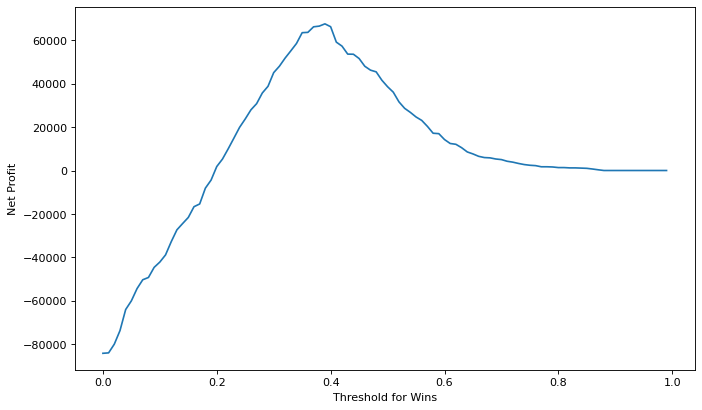

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)

dogOutput = calculateMaxProfitability(dog_data_train, Y_train, 'dog')

print(dogOutput[0][35:45])
print(dogOutput[1][35:45])

plt.plot(dogOutput[0], dogOutput[1], label="Profitability")
plt.xlabel("Threshold for Wins")
plt.ylabel("Net Profit")

(array([311., 449., 423., 544., 691., 810., 895., 997., 971., 874., 725.,
        492., 309., 184.,  98.,  43.,  25.,  11.,   3.,   7.]),
 array([0.00359162, 0.04709798, 0.09060434, 0.1341107 , 0.17761706,
        0.22112341, 0.26462978, 0.30813614, 0.3516425 , 0.39514884,
        0.4386552 , 0.48216158, 0.5256679 , 0.5691743 , 0.6126807 ,
        0.656187  , 0.6996934 , 0.7431997 , 0.7867061 , 0.8302124 ,
        0.8737188 ], dtype=float32),
 <a list of 20 Patch objects>)

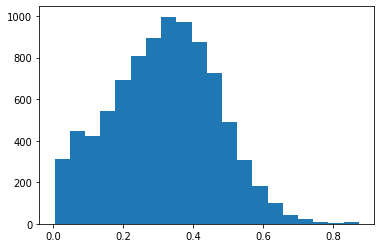

In [ ]:
# Histogram
plt.hist(Y_train, bins = 20)

1853.9393939393867
730
0.422


Text(0, 0.5, 'Net Profit')

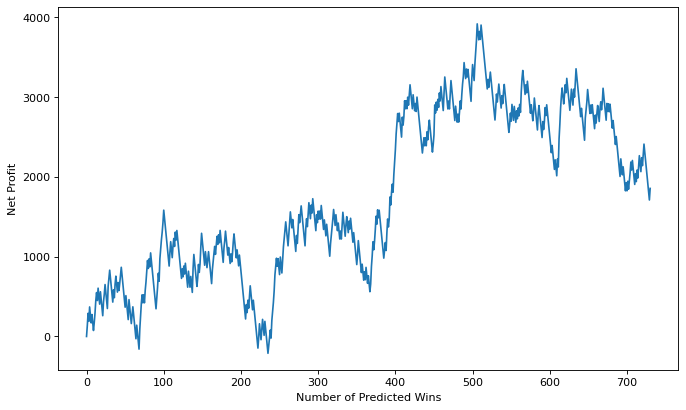

In [ ]:
# Profits over time
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)


profits = calculateProfitability(.39, 'dog', dog_data_test, Y_test)
print(profits[0])
print(findPrecision(.39, Y_test, T_test,  verbose = True))

plt.plot(profits[2], profits[1], label="Profitability")
plt.xlabel("Number of Predicted Wins")
plt.ylabel("Net Profit")

27
0.741
1806.385281385281


Text(0, 0.5, 'Net Profit')

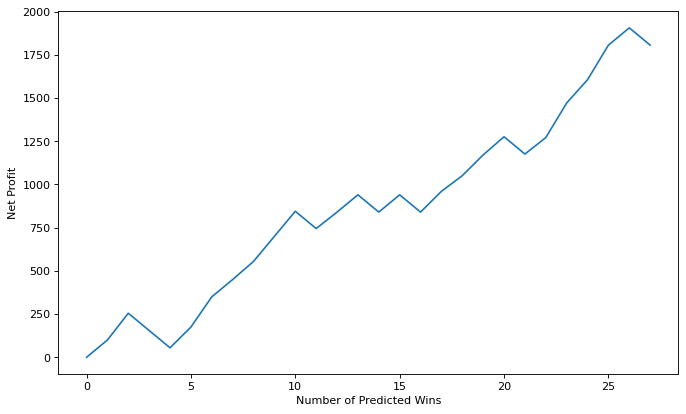

In [ ]:
# Profits over time
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)


profits = calculateProfitability(.66, 'dog', dog_data_test, Y_test)
print(findPrecision(.66, Y_test, T_test,  verbose = True))
print(profits[0])

plt.plot(profits[2], profits[1], label="Profitability")
plt.xlabel("Number of Predicted Wins")
plt.ylabel("Net Profit")

## Favorites

In [ ]:
teamType = 'fav'

if teamType == 'dog':
  X_train = dog_data_train.loc[:, dog_data_train.columns != 'dog_wins'].to_numpy()
  T_train = dog_data_train.loc[:, dog_data_train.columns == 'dog_wins'].to_numpy()

  X_test = dog_data_test.loc[:, dog_data_test.columns != 'dog_wins'].to_numpy()
  T_test = dog_data_test.loc[:, dog_data_test.columns == 'dog_wins'].to_numpy()
else:
  X_train = fav_data_train.loc[:, fav_data_train.columns != 'fav_wins'].to_numpy()
  T_train = fav_data_train.loc[:, fav_data_train.columns == 'fav_wins'].to_numpy()

  X_test = fav_data_test.loc[:, fav_data_test.columns != 'fav_wins'].to_numpy()
  T_test = fav_data_test.loc[:, fav_data_test.columns == 'fav_wins'].to_numpy()

In [ ]:
# Train best model
n_samples, n_inputs = X_train.shape
n_epochs = 10000
batch_size = 500
learning_rate = 0.001

final_fav_net = BinClassModel(n_inputs, [], 'tanh', 0)
final_fav_net.train(X_train, T_train, batch_size, n_epochs, learning_rate, 'adam', verbose = True)
print()

adam: Epoch 1000 Loss 0.574
adam: Epoch 2000 Loss 0.568
adam: Epoch 3000 Loss 0.568
adam: Epoch 4000 Loss 0.568
adam: Epoch 5000 Loss 0.567
adam: Epoch 6000 Loss 0.567
adam: Epoch 7000 Loss 0.567
adam: Epoch 8000 Loss 0.567
adam: Epoch 9000 Loss 0.567
adam: Epoch 10000 Loss 0.567



In [ ]:
# Testing out precision function
Y_train = final_fav_net.use(X_train)
Y_test = final_fav_net.use(X_test)
fav_probs = final_fav_net.use(X_train)
print(findPrecision(.65, Y_test, T_test,  verbose = True))

1296
0.762


[0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69]
[33498.77495839985, 35077.89913275555, 34751.52038838948, 35233.45889453557, 35565.34229761119, 35958.26904049582, 34288.82857627981, 33390.3247036524, 32496.01006473048, 31284.613078775357]


Text(0, 0.5, 'Net Profit')

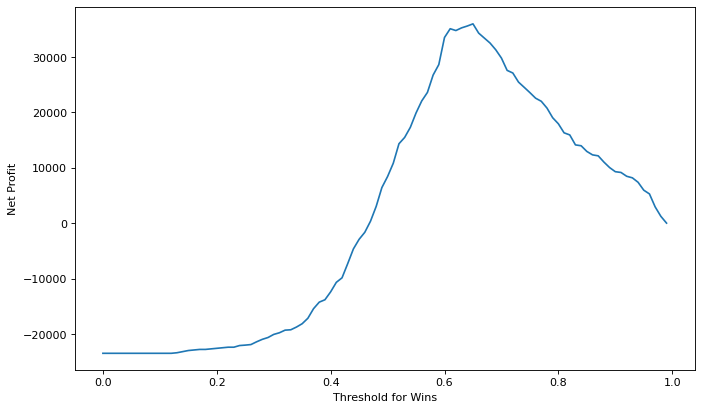

In [ ]:
figure(figsize=(10, 6), dpi=80)

favOutput = calculateMaxProfitability(fav_data_train, Y_train, 'fav')
print(favOutput[0][60:70])
print(favOutput[1][60:70])

plt.plot(favOutput[0], favOutput[1], label="Profitability")
plt.xlabel("Threshold for Wins")
plt.ylabel("Net Profit")

(array([  7.,   3.,  11.,  25.,  44.,  97., 183., 309., 490., 726., 876.,
        971., 996., 894., 812., 691., 544., 423., 449., 311.]),
 array([0.12623557, 0.1697452 , 0.21325482, 0.25676444, 0.30027407,
        0.3437837 , 0.38729334, 0.43080294, 0.47431257, 0.5178222 ,
        0.5613318 , 0.6048415 , 0.6483511 , 0.6918607 , 0.73537034,
        0.77887994, 0.8223896 , 0.8658992 , 0.9094088 , 0.95291847,
        0.9964281 ], dtype=float32),
 <a list of 20 Patch objects>)

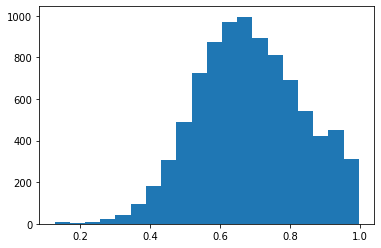

In [ ]:
# Histogram
plt.hist(Y_train, bins = 20)

3078.7173814155326
1298
0.763


Text(0, 0.5, 'Net Profit')

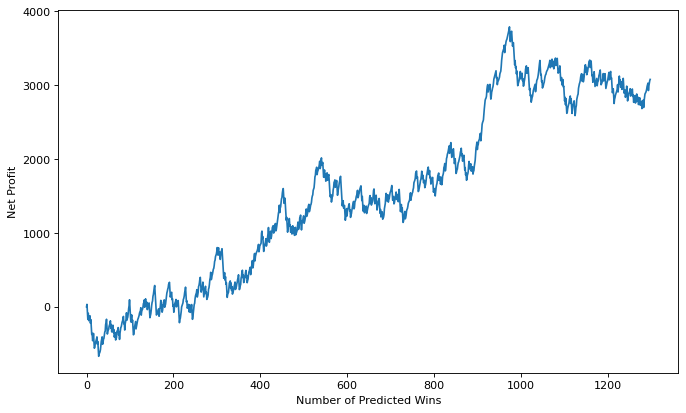

In [ ]:
# Profits over time
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)


profits = calculateProfitability(.65, 'fav', fav_data_test, Y_test)
print(profits[0])
print(findPrecision(.65, Y_test, T_test,  verbose = True))

plt.plot(profits[2], profits[1], label="Profitability")
plt.xlabel("Number of Predicted Wins")
plt.ylabel("Net Profit")

222
0.914
2328.723456215047


Text(0, 0.5, 'Net Profit')

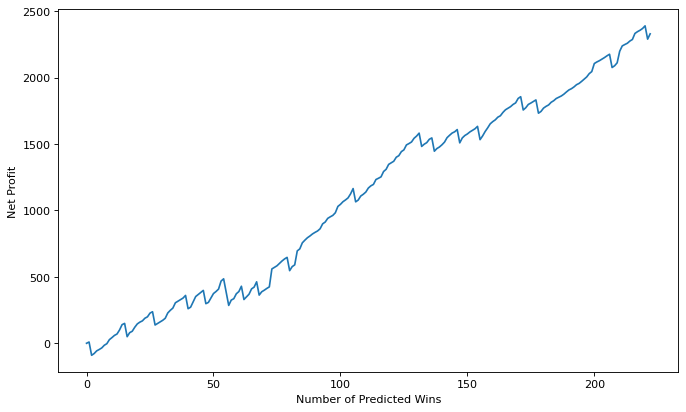

In [ ]:
# Profits over time
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)


profits = calculateProfitability(.90, 'fav', fav_data_test, Y_test)
print(findPrecision(.90, Y_test, T_test,  verbose = True))
print(profits[0])

plt.plot(profits[2], profits[1], label="Profitability")
plt.xlabel("Number of Predicted Wins")
plt.ylabel("Net Profit")